# Import Necessary Packages

In [ ]:
# Install all necessary packages for this notebook (API in brackets for convenience)

!pip install yfinance # https://pypi.org/project/yfinance/
!pip install praw  # https://pypi.org/project/praw/
!pip install json # https://docs.python.org/3/library/json.html
!pip install requests # https://pypi.org/project/requests/
!pip install pygooglenews # https://pypi.org/project/pygooglenews/
!pip install vaderSentiment # https://pypi.org/project/vaderSentiment/
!pip install emoji # https://pypi.org/project/emoji/
!pip install zeugma  # https://zeugma.readthedocs.io/
!pip install regex # https://docs.python.org/3/library/re.html
!pip install nltk  # https://www.nltk.org/
!pip install matplotlib.pyplot # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html
!pip intall keras  # https://keras.io/
!pip install sklearn # https://scikit-learn.org/
%matplotlib inline

# Import necessary files
import math
import pandas as pd
import numpy as np
import regex as re
import string
import keras
import nltk
import emoji
import pytz
import collections
import json
import gc
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
import os, logging' 
import warnings

# Import Sklearn packages
from sklearn import datasets, linear_model, svm
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.naive_bayes import BernoulliNB,  MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import TimeSeriesSplit,  GridSearchCV, train_test_split

# Import necessary files for time conversion and data collection
from datetime import datetime, timedelta
from pygooglenews import GoogleNews
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from keras.layers import Dense, Dropout, Activation
from collections import Counter

# Import additional files, including NLTK and WordNet corpus
from datetime import datetime, timedelta
from pygooglenews import GoogleNews
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from keras.layers import Dense, Dropout, Activation
from collections import Counter
from google.colab import files
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english')) - {'all'}

# Remove Deprecated warnings
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3
warnings.filterwarnings('ignore')

# Connect to Drive
from google.colab import drive
drive.mount('/content/drive')

     |████████████████████████████████| 163kB 6.1MB/s 
     |████████████████████████████████| 71kB 5.6MB/s 
ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json
     |████████████████████████████████| 368kB 6.0MB/s 
     |████████████████████████████████| 122kB 9.8MB/s 
     |████████████████████████████████| 61kB 5.1MB/s 
     |████████████████████████████████| 194kB 6.8MB/s 
  Created wheel for feedparser: filename=feedparser-5.2.1-cp37-none-any.whl size=44940 sha256=51cc694c19b0199a96d4d148428698e0dae232236b9be5bbe2f8511877a3e7c4
  Stored in directory: /root/.cache/pip/wheels/8c/69/b7/f52763c41c5471df57703a0ef718a32a5e81ee35dcf6d4f97f
Successfully built feedparser
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existin

# Data Set Collection & Preprocessing and Sentiment Analysis

## Google News

### Data Collection

In [ ]:
# Three parallel arrays with necessary stock information:

# All companies search queries 
companies = ["'intitle:Gamestop' OR 'intitle:GME'", "'intitle:AMC+Cinemas' OR 'intitle:AMC'",
             "'intitle:Nokia' OR 'intitle:NOK'", "'intitle:Tesla' OR 'intitle:TSLA'",
             "'intitle:BlackBerry' OR 'intitle:BB'", "'intitle:Koss' OR 'intitle:KOSS'",
             "'intitle:Express+Inc' OR 'intitle:EXPR'",
             "'intitle:Microsoft' OR 'intitle:MSFT'",  "'intitle:Facebook' OR 'intitle:FB'", 
             "'intitle:Amazon' OR 'intitle:AMZN'", 
             "'intitle:Google' OR 'intitle:GOOGL'", "'intitle:Apple' OR 'intitle:AAPL'", 
             "'intitle:Netflix' OR 'intitle:NFLX'", "'intitle:Alibaba' OR 'intitle:BABA'",
             "'intitle:Royal+Caribbean' OR 'intitle:RCL'", "'intitle:Carnival' OR 'intitle:CCL'",
             "intitle:Beyond+Meat", "'intitle:Zoom' OR 'intitle:ZM'",
             "'intitle:American+Airlines' OR 'intitle:AAL'", "intitle:Boeing",
             "intitle:Moderna"]

# Company stock tickers        
compName = ['GME', 'AMC', 'NOK', 'TSLA', 'BB', 'KOSS', 'EXPR',
            'MSFT', 'FB', 'AMZN', 'GOOGL', 'AAPL', 'NFLX', 'BABA',
            'RCL', 'CCL', 'BY', 'ZM', 'AAL', 'BA', 'MRNA']

# Company type
compType = ['Hype', 'Hype', 'Hype', 'Hype', 'Hype', 'Hype', 'Hype',
            'Lead', 'Lead', 'Lead', 'Lead', 'Lead', 'Lead', 'Lead',
            'Volat', 'Volat', 'Volat', 'Volat', 'Volat', 'Volat', 'Volat']

# Extract data from Google News API one company at a time            
index = 0
dfBig = pd.DataFrame([], columns = ['type', 'company', 'title', 'source', 'd', 'm', 'y'])
for company in companies:
  gn = GoogleNews(lang = 'en', country ='US')
  start_date = datetime.date(2020, 10, 1)
  end_date = datetime.date(2021, 4, 29)
  delta = datetime.timedelta(days=1)

# For every day in interval
  while start_date <= end_date:
    cur = start_date
    start_date += delta
    next = start_date
    s = gn.search(company, from_=str(cur), to_=str(next))
    for entry in s['entries']:
      # For entry get date, source, and title
      if entry.has_key('title'):
        title = (entry['title'])
        year = (entry['published_parsed'].tm_year)
        month = (entry['published_parsed'].tm_mon)
        day = (entry['published_parsed'].tm_mday)
        source = (entry['source'].title)
        dfCur = pd.DataFrame([[compType[index], compName[index], title, source, day, month, year]], columns = ['type', 'company', 'title', 'source', 'd', 'm', 'y'])
        dfBig = dfBig.append(dfCur)
  print(company)
  index += 1
dfBig = dfBig.reset_index()
#dfBig = dfBig.drop('level_0', axis=1)    # If necessary only
dfBig = dfBig.drop('index', axis=1)

# Export extracted dat
filename = r"/content/drive/Shareddrives/COS424/NewsAll.csv"
dfBig.to_csv(filename, index=False)

2020-10-01
2020-10-02
2020-10-03
2020-10-04
2020-10-05
2020-10-06
2020-10-07
2020-10-08
2020-10-09
2020-10-10
2020-10-11
2020-10-12
2020-10-13
2020-10-14
2020-10-15
2020-10-16
2020-10-17
2020-10-18
2020-10-19
2020-10-20
2020-10-21
2020-10-22
2020-10-23
2020-10-24
2020-10-25
2020-10-26
2020-10-27
2020-10-28
2020-10-29
2020-10-30
2020-10-31
2020-11-01
2020-11-02
2020-11-03
2020-11-04
2020-11-05
2020-11-06
2020-11-07
2020-11-08
2020-11-09
2020-11-10
2020-11-11
2020-11-12
2020-11-13
2020-11-14
2020-11-15
2020-11-16
2020-11-17
2020-11-18
2020-11-19
2020-11-20
2020-11-21
2020-11-22
2020-11-23
2020-11-24
2020-11-25
2020-11-26
2020-11-27
2020-11-28
2020-11-29
2020-11-30
2020-12-01
2020-12-02
2020-12-03
2020-12-04
2020-12-05
2020-12-06
2020-12-07
2020-12-08
2020-12-09
2020-12-10
2020-12-11
2020-12-12
2020-12-13
2020-12-14
2020-12-15
2020-12-16
2020-12-17
2020-12-18
2020-12-19
2020-12-20
2020-12-21
2020-12-22
2020-12-23
2020-12-24
2020-12-25
2020-12-26
2020-12-27
2020-12-28
2020-12-29
2020-12-30

### Preprocessing

In [ ]:
# Gets the part of speech tag of word for lemmatization
# This function is based on code from:
#   https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Preprocesses the tweets text
# This function is based on code from:
#   https://www.pluralsight.com/guides/building-a-twitter-sentiment-analysis-in-python

# Preprocessing takes in a tweet and a boolean determining if the preprocessing
# is for the GloVe embeddings or for other classifiers
# default value is: False

def preprocess_text(tweet):
    # Changes emojis to words
    tweet = emoji.demojize(tweet,  delimiters=(' ', ' '))
    # Removes capitalization
    tweet = tweet.lower()
    # Removes single characters
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
    # Removes all hashtags
    tweet = re.sub(r'#[a-zA-Z0-9]+\s+', ' ', tweet)
    # Removes all special characters
    tweet = re.sub(r'\W', ' ', tweet)
    #Removes Punctuation
    tweet = re.sub(r'\p{P}+', '', tweet)
    #Removes multiple spaces with single space
    tweet = re.sub(r'\s+', ' ', tweet, flags=re.MULTILINE)
    # Removes stopwords
    tokens = [w for w in word_tokenize(tweet) if not w in stop_words]
    # Perfoms lemmatization on tokens
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    return " ".join(lemma_words)

In [ ]:
# Add cleaned title column and preprocess text
dfBig['titleClean'] = ''
index = 0
for title in dfBig['title']:
  dfBig['titleClean'][index] = preprocess_text(title)
  index += 1

In [ ]:
# Export Cleaned News Data
filename = r"/content/drive/Shareddrives/COS424/NewsAllClean.csv"
dfBig.to_csv(filename, index=False)

### Sentiment Analysis

In [ ]:
# Start VADER sentiment analysis and store resulting scores for every post

analyzer = SentimentIntensityAnalyzer()
news = r"/content/drive/Shareddrives/COS424/NewsAllClean.csv" # Exported Cleaned News Data
news_df = pd.read_csv(news)
sentences = news_df['titleClean']
index = 0

news_df['comp'] = 0.0  # Compound
news_df['neg'] = 0.0   # Positivity
news_df['neu'] = 0.0   # Negativity
news_df['pos'] = 0.0   # Positivity

# For every headline, get score
for sentence in sentences:
  if type(sentence) != float:
    vs = analyzer.polarity_scores(sentence)
    news_df['comp'][index] = vs['compound']
    news_df['neg'][index] = vs['neg']
    news_df['neu'][index] = vs['neu']
    news_df['pos'][index] = vs['pos']
  index +=1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/i

In [ ]:
# Add date column as index

df = pd.DataFrame({'year': news_df['y'],
                   'month': news_df['m'],
                   'day': news_df['d']})
dates = pd.to_datetime(df)
news_df['date']=dates
news_df = news_df.set_index('date')

In [ ]:
# Sum up sentiment scores of all headlines for every single day 

new_news = pd.DataFrame(columns=["date",'sum', 'pos', 'neg', 'neu', 'num','company'])

# List companies again for convenience
compName = ['GME', 'AMC', 'NOK', 'TSLA', 'BB', 'KOSS', 'EXPR',
          'MSFT', 'FB', 'AMZN', 'GOOGL', 'AAPL', 'NFLX', 'BABA',
        'RCL', 'CCL', 'BY', 'ZM', 'AAL', 'BA', 'MRNA']

compType = ['Hype', 'Hype', 'Hype', 'Hype', 'Hype', 'Hype', 'Hype',
            'Lead', 'Lead', 'Lead', 'Lead', 'Lead', 'Lead', 'Lead',
            'Volat', 'Volat', 'Volat', 'Volat', 'Volat', 'Volat', 'Volat']

# For every company extract day's sentiment
for company in compName:
  df = news_df[news_df.company == company]
  

  for date in np.unique(df.index):
    comp = df.loc[[date],['comp']]
    pos = df.loc[[date],['pos']]
    neg = df.loc[[date],['neg']]
    neu = df.loc[[date],['neu']] 
    sum=0
    sumP=0
    sumNeg=0
    sumNeu=0

    # Sum compound score
    for i in range(len(comp)):
      val=comp.iloc[i, 0]
      sum+=val
    num = len(comp.index)

    # Sum positivity score
    for i in range(len(pos)):
      val=pos.iloc[i, 0]
      sumP+=val

    # Sum negativity score
    for i in range(len(neg)):
      val=neg.iloc[i, 0]
      sumNeg+=val
    
    # Sum neutrality score
    for i in range(len(neu)):
      val=neu.iloc[i, 0]
      sumNeu+=val
    
    new_news.loc[len(new_news.index)] = [date, sum, sumP, sumNeg, sumNeu, num, company] 

In [ ]:
# Export data ready for Prediction
new_news['avg']=new_news['sum']/new_news['num'] # Add average daily score column
filename = r"/content/drive/Shareddrives/COS424/news_compound_scores.csv"
new_news.to_csv(filename)

## Reddit

### Data Collection

Note: The below section requires Reddit API Access & Authentication. Account information has been redacted and the necessary portions have been commented out

In [ ]:
# REDDIT API ACCESS & AUTHENTICATION
# NOTE: username & password REDACTED // THIS SECTION IS NOT RUNABLE

# note that CLIENT_ID refers to 'personal use script' and SECRET_TOKEN to 'token'
# auth = requests.auth.HTTPBasicAuth('REDACTED', 'REDACTED')

# here we pass our login method (password), username, and password
data = {'grant_type': 'password',
        'username': 'REDACTED',
        'password': 'REDACTED'}

# setup our header info, which gives reddit a brief description of our app
headers = {'User-Agent': 'MyBot/0.0.1'}

# send our request for an OAuth token
# res = requests.post('https://www.reddit.com/api/v1/access_token',
#                    auth=auth, data=data, headers=headers)

# convert response to JSON and pull access_token value
# TOKEN = res.json()['access_token']

# add authorization to our headers dictionary
# headers = {**headers, **{'Authorization': f"bearer {TOKEN}"}}

# while the token is valid (~2 hours) we just add headers=headers to our requests
# requests.get('https://oauth.reddit.com/api/v1/me', headers=headers)

In [ ]:
# Three parallel arrays with necessary stock information:

companies = ['Gamestop|GME', 'AMC', 'Nokia|NOK', 'Tesla|TSLA', 'BlackBerry|BB', 'KOSS', 'Express|EXPR',
            'Microsoft|MSFT', 'Facebook|FB', 'Amazon|AMZN', 'Google|GOOGL', 'Apple|AAPL', 'Netflix|NFLX', 'Alibaba|BABA',
            '"Royal Caribbea|RCL"', 'Carnival|CCL', '"Beyond Meat|BY"', 'Zoom|ZM', '"American Airlines"|AAL', 'Boeing|BA', 'Moderna|MRNA']

compName = ['GME', 'AMC', 'NOK', 'TSLA', 'BB', 'KOSS', 'EXPR',
            'MSFT', 'FB', 'AMZN', 'GOOGL', 'AAPL', 'NFLX', 'BABA',
            'RCL', 'CCL', 'BY', 'ZM', 'AAL', 'BA', 'MRNA']

compType = ['Hype', 'Hype', 'Hype', 'Hype', 'Hype', 'Hype', 'Hype',
            'Lead', 'Lead', 'Lead', 'Lead', 'Lead', 'Lead', 'Lead',
            'Volat', 'Volat', 'Volat', 'Volat', 'Volat', 'Volat', 'Volat']


arrM = ['10', '11', '12', '01', '02', '03', '04'] # Month we look at
arrD = [31, 30, 31, 31, 28, 31, 29] # Days per month (note: we end April 29th)

dfBig = pd.DataFrame([], columns = ['type', 'company', 'created_utc', 'title', 'score', 'upvote_ratio', 'selftext'])
year = '2020-'
counter = 0

# For every company
for company in companies:
  # Compute date for extraction purposes:
  year = '2020-'
  index = 0
  for month in arrM:
    if index >= 3:
      year = '2021-'
    for day in range(1, arrD[index] + 1):
      if day < 10:
        dateFrom = year + str(arrM[index]) + "-0" + str(day)
        if day + 1 < 10:
          dateTo = year + str(arrM[index]) + "-0" + str(day + 1)
        else:
          dateTo = year + str(arrM[index]) + "-" + str(day + 1)
    
      elif day + 1 > arrD[index]:
        dateFrom = year + str(arrM[index]) + "-" + str(day)
        if index != 6:
          dateTo = year + str(arrM[index + 1]) + "-01"
        else:
          dateTo = year + str(arrM[index]) + "-" + str(day + 1)

      else:
        dateFrom = year + str(arrM[index]) + "-" + str(day)
        dateTo = year + str(arrM[index]) + "-" + str(day + 1)

      # Get data from PushShift Reddit API
      url = "https://api.pushshift.io/reddit/search/submission/?subreddit=wallstreetbets&size=500&sort_type=score&sort=desc&fields=title,score,upvote_ratio,selftext,created_utc&title=" + company + "&after="
      urlFull = url + dateFrom + "&before=" + dateTo
      res = requests.get(urlFull)
      #Attempt three times, just in case of connectivity issues
      # If data retrieved: at to dfBig
      try:
        # print(res.json()['data']) # let's see what we get
        df = pd.DataFrame.from_dict(res.json()['data'])
        df.insert(0, 'company', compName[counter])
        df.insert(0, 'type', compType[counter])
        dfBig = dfBig.append(df)
      except: 
        try: 
          res = requests.get(urlFull)
          df = pd.DataFrame.from_dict(res.json()['data'])
          df.insert(0, 'company', compName[counter])
          df.insert(0, 'type', compType[counter])
          dfBig = dfBig.append(df)
        except:
          try: 
            time.sleep(0.5)
            res = requests.get(urlFull)
            df = pd.DataFrame.from_dict(res.json()['data'])
            df.insert(0, 'company', compName[counter])
            df.insert(0, 'type', compType[counter])
            dfBig = dfBig.append(df)
          except:
            try: 
              time.sleep(0.5)
              res = requests.get(urlFull)
              df = pd.DataFrame.from_dict(res.json()['data'])
              df.insert(0, 'company', compName[counter])
              df.insert(0, 'type', compType[counter])
              dfBig = dfBig.append(df)
            except:
              print(dateFrom + "= NONE")
    index += 1
    
  counter += 1
  print(company)

# Export all data for cleaning:
filename = r"/content/drive/Shareddrives/COS424/RedditAllBigNOCLEAN.csv"
dfBig.to_csv(filename, index=False)

10
11
12
01
02
03
04
Gamestop|GME
    type  ...                                           selftext
0   Hype  ...  Hey guys, i am looking at the jan 2021 calls o...
1   Hype  ...                                          [removed]
2   Hype  ...    \n\nCredit for this information goes to Just...
0   Hype  ...  Can we get an actual discussion regarding what...
0   Hype  ...  **Never chase a stock as it rises.  So I ended...
..   ...  ...                                                ...
85  Hype  ...                                                   
86  Hype  ...                                                   
87  Hype  ...                                                   
88  Hype  ...  The current short value of UNFI is 45%... the ...
89  Hype  ...                                                   

[11837 rows x 7 columns]
10
11
12
01
02
03
04
AMC
    type  ...                                           selftext
0   Hype  ...  Hey guys, i am looking at the jan 2021 calls o...
1   H

### Preprocessing

In [ ]:
# Change Unix Epoch time to EST time (for stock analysis)

dfBig = dfBig.reset_index(drop=True)
dfBig['minute'] = 0
dfBig['hour'] = 0
dfBig['day'] = 0
dfBig['month'] = 0 
dfBig['year'] = 0
dfBig['est'] = 0

# transform time to NYC time
tz = pytz.timezone('America/New_York')
index = 0
print(dfBig)
for row in dfBig.iterrows():
  utc = row[1][2]
  est = datetime.fromtimestamp(utc, tz)
  strEst = est.strftime('%Y-%m-%d %H:%M:%S')
  dfBig['year'][index] = est.strftime('%Y')
  dfBig['month'][index] = est.strftime('%m')
  dfBig['day'][index] = est.strftime('%d')
  dfBig['hour'][index] = est.strftime('%H')
  dfBig['minute'][index] = est.strftime('%M')
  dfBig['est'][index] = strEst
  index += 1

print(dfBig) # Print resulting array with correct time

        type company created_utc  ... month year  est
0       Hype     GME  1601541801  ...     0    0    0
1       Hype     GME  1601593943  ...     0    0    0
2       Hype     GME  1601522978  ...     0    0    0
3       Hype     GME  1601669797  ...     0    0    0
4       Hype     GME  1601705389  ...     0    0    0
...      ...     ...         ...  ...   ...  ...  ...
43180  Volat    MRNA  1619039554  ...     0    0    0
43181  Volat    MRNA  1619085548  ...     0    0    0
43182  Volat    MRNA  1619219619  ...     0    0    0
43183  Volat    MRNA  1619458258  ...     0    0    0
43184  Volat    MRNA  1619685317  ...     0    0    0

[43185 rows x 13 columns]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to b

        type company created_utc  ... month  year                  est
0       Hype     GME  1601541801  ...    10  2020  2020-10-01 04:43:21
1       Hype     GME  1601593943  ...    10  2020  2020-10-01 19:12:23
2       Hype     GME  1601522978  ...     9  2020  2020-09-30 23:29:38
3       Hype     GME  1601669797  ...    10  2020  2020-10-02 16:16:37
4       Hype     GME  1601705389  ...    10  2020  2020-10-03 02:09:49
...      ...     ...         ...  ...   ...   ...                  ...
43180  Volat    MRNA  1619039554  ...     4  2021  2021-04-21 17:12:34
43181  Volat    MRNA  1619085548  ...     4  2021  2021-04-22 05:59:08
43182  Volat    MRNA  1619219619  ...     4  2021  2021-04-23 19:13:39
43183  Volat    MRNA  1619458258  ...     4  2021  2021-04-26 13:30:58
43184  Volat    MRNA  1619685317  ...     4  2021  2021-04-29 04:35:17

[43185 rows x 13 columns]


In [ ]:
# Gets the part of speech tag of word for lemmatization
# This function is based on code from:
#   https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Preprocesses the tweets text
# This function is based on code from:
#   https://www.pluralsight.com/guides/building-a-twitter-sentiment-analysis-in-python

# Preprocessing takes in a tweet and a boolean determining if the preprocessing
# is for the GloVe embeddings or for other classifiers
# default value is: False

def preprocess_text(tweet):
    tweet = re.sub(r'🚀', ' winner ', tweet)
    # Changes emojis to words
    tweet = emoji.demojize(tweet,  delimiters=(' ', ' '))
    # Removes capitalization
    tweet = tweet.lower()
    # Encode Subreddit Vernacular 
    tweet = re.sub(r'buy', 'good', tweet)
    tweet = re.sub(r'sell', 'bad', tweet)
    tweet = re.sub(r'to the moon', 'winner', tweet)
    tweet = re.sub(r'short squeeze', 'winner', tweet)
    
    # Removes single characters
    tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
    # Removes all hashtags
    tweet = re.sub(r'#[a-zA-Z0-9]+\s+', ' ', tweet)
    # Removes all special characters
    tweet = re.sub(r'\W', ' ', tweet)
    #Removes Punctuation
    tweet = re.sub(r'[^\w\s]','',tweet)
    #Removes multiple spaces with single space
    tweet = re.sub(r'\s+', ' ', tweet, flags=re.MULTILINE)
    # Removes stopwords
    tokens = [w for w in word_tokenize(tweet) if not w in stop_words]
    # Perfoms lemmatization on tokens
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    return " ".join(lemma_words)

In [ ]:
# Clean both title and body text using above preprocessing code:
dfBigCopy = dfBig.copy()
dfBig['titleClean'] = ''
dfBig['bodyClean'] = ''

index = 0
for title in dfBig['title']:
  dfBig['titleClean'][index] = preprocess_text(title)
  index += 1

index = 0
for body in dfBig['selftext']:
  if type(body) == str:
    dfBig['bodyClean'][index] = preprocess_text(body)
  # If post removed or delated, remove text to avoid wrong sentiment, 
  # but keep for volume calculations
  if dfBig['bodyClean'][index] == 'remove':
    dfBig['bodyClean'][index] = ''
  if dfBig['bodyClean'][index] == 'delete':
    dfBig['bodyClean'][index] = ''
  index += 1

print(dfBig) # Print resulting array

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ip

        type  ...                                          bodyClean
0       Hype  ...  hey guy look jan 2021 call gme even 22 price m...
1       Hype  ...                                                   
2       Hype  ...  credit information go justin dopierala founder...
3       Hype  ...  get actual discussion regard fuck go gme somet...
4       Hype  ...  never chase stock rise end catch good day day ...
...      ...  ...                                                ...
43180  Volat  ...  see part 1 http www reddit com r wallstreetbet...
43181  Volat  ...  biontech market cap 39b moderna 67b one commer...
43182  Volat  ...                                                   
43183  Volat  ...  mrna completely overvalue many additional mrna...
43184  Volat  ...                                                   

[43185 rows x 15 columns]


In [ ]:
# Export Cleaned Data
filename = r"/content/drive/Shareddrives/COS424/RedditAllBigClean.csv"
dfBig.to_csv(filename, index=False)

### Sentiment Analysis

In [ ]:
# Start VADER sentiment analysis and store resulting scores for every post
# For more thorough commenting go to "Google News - Sentiment Analysis" (similar code)

analyzer = SentimentIntensityAnalyzer()
reddit = r"/content/drive/Shareddrives/COS424/RedditAllBigClean.csv" # Cleaned Reddit Data
reddit_df = pd.read_csv(reddit)
print(reddit_df)
sentences = reddit_df['titleClean']
scores = []
index = 0

reddit_df['comp'] = 0.0
reddit_df['neg'] = 0.0
reddit_df['neu'] = 0.0
reddit_df['pos'] = 0.0

for sentence in sentences:
  if type(sentence) != float:
    vs = analyzer.polarity_scores(sentence)
    reddit_df['comp'][index] = vs['compound']
    reddit_df['neg'][index] = vs['neg']
    reddit_df['neu'][index] = vs['neu']
    reddit_df['pos'][index] = vs['pos']
  index +=1

# Repeat for body text
sentences = reddit_df['bodyClean']
scores = []
index = 0

reddit_df['compB'] = 0.0
reddit_df['negB'] = 0.0
reddit_df['neuB'] = 0.0
reddit_df['posB'] = 0.0

for sentence in sentences:
  if type(sentence) != float:
    vs = analyzer.polarity_scores(sentence)
    reddit_df['compB'][index] = vs['compound']
    reddit_df['negB'][index] = vs['neg']
    reddit_df['neuB'][index] = vs['neu']
    reddit_df['posB'][index] = vs['pos']
  index +=1

        type  ...                                          bodyClean
0       Hype  ...  hey guy look jan 2021 call gme even 22 price m...
1       Hype  ...                                                NaN
2       Hype  ...  credit information go justin dopierala founder...
3       Hype  ...  get actual discussion regard fuck go gme somet...
4       Hype  ...  never chase stock rise end catch good day day ...
...      ...  ...                                                ...
43180  Volat  ...  see part 1 http www reddit com r wallstreetbet...
43181  Volat  ...  biontech market cap 39b moderna 67b one commer...
43182  Volat  ...                                                NaN
43183  Volat  ...  mrna completely overvalue many additional mrna...
43184  Volat  ...                                                NaN

[43185 rows x 15 columns]
{'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compound': 0.7096}


In [ ]:
# Add date column as index

df = pd.DataFrame({'year': reddit_df['year'],
                   'month': reddit_df['month'],
                   'day': reddit_df['day']})
dates = pd.to_datetime(df)
reddit_df['date']=dates
reddit_df = reddit_df.set_index('date')

In [ ]:
new_reddit = pd.DataFrame(columns=["date",'comp','pos', 'neg', 'neu', 'sumB', 'posB', 'neuB', 'negB', 'num','company'])


# For every company extract day's sentiment
for company in compName:
  df = reddit_df[reddit_df.company == company]
  
 # Sum up all sentiment in one day
  for date in np.unique(df.index):
    comp = df.loc[[date],['comp']]
    pos = df.loc[[date],['pos']]
    neg = df.loc[[date],['neg']]
    neu = df.loc[[date],['neu']]

    compB = df.loc[[date],['compB']]
    posB = df.loc[[date],['posB']]
    negB = df.loc[[date],['negB']]
    neuB = df.loc[[date],['neuB']]
    
    sum=0
    sumP=0
    sumNeg=0
    sumNeu=0

    for i in range(len(comp)):
      val=comp.iloc[i, 0]
      sum+=val
    num = len(comp.index)

    for i in range(len(pos)):
      val=pos.iloc[i, 0]
      sumP+=val

    for i in range(len(neg)):
      val= neg.iloc[i, 0]
      sumNeg+=val
    
    for i in range(len(neu)):
      val=neu.iloc[i, 0]
      sumNeu+=val
    
    # Repeat for body text
    bsum=0
    bsumP=0
    bsumNeg=0
    bsumNeu=0

    for i in range(len(compB)):
      val=compB.iloc[i, 0]
      bsum+=val

    for i in range(len(posB)):
      val=posB.iloc[i, 0]
      bsumP+=val

    for i in range(len(negB)):
      val=negB.iloc[i, 0]
      bsumNeg+=val
    
    for i in range(len(neuB)):
      val=neuB.iloc[i, 0]
      bsumNeu+=val

    new_reddit.loc[len(new_reddit.index)] = [date, sum, sumP, sumNeg, sumNeu, bsum, bsumP, bsumNeg, bsumNeu, num, company] 

In [ ]:
# Export Reddit Sentiment Scored Data Set
new_reddit['avg']=new_reddit['comp']/new_reddit['num'] # Add average compound score (for feature selection)
new_reddit['sum'] = new_reddit['comp']
filename = r"/content/drive/Shareddrives/COS424/reddit_compound_scores.csv"
new_reddit.to_csv(filename)

## Yahoo Finance

### Data Collection

GME
[*********************100%***********************]  1 of 1 completed
                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2020-10-01   10.090000   10.250000  ...    9.770000   4554100
2020-10-02    9.380000    9.780000  ...    9.390000   4340500
2020-10-05    9.440000    9.590000  ...    9.460000   2805000
2020-10-06    9.560000    9.840000  ...    9.130000   4535400
2020-10-07    9.230000    9.560000  ...    9.360000   3308600
...                ...         ...  ...         ...       ...
2021-04-22  159.100006  159.100006  ...  151.169998   4345800
2021-04-23  149.000000  153.660004  ...  151.179993   4029100
2021-04-26  150.979996  174.679993  ...  168.929993  10532100
2021-04-27  183.550003  188.000000  ...  177.770004   8932700
2021-04-28  172.100006  181.979996  ...  178.580002   5788900

[144 rows x 6 columns]


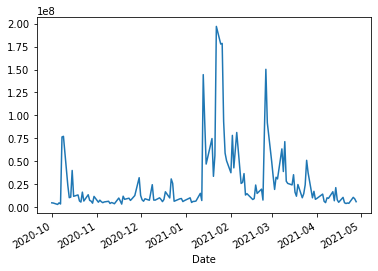

AMC
[*********************100%***********************]  1 of 1 completed
             Open   High    Low  Close  Adj Close    Volume
Date                                                       
2020-10-01   4.78   4.80   4.63   4.65       4.65   3223800
2020-10-02   4.48   4.66   4.42   4.65       4.65   3576000
2020-10-05   4.30   4.36   4.05   4.13       4.13   9468800
2020-10-06   4.26   4.27   4.05   4.06       4.06   8404200
2020-10-07   4.08   4.11   3.94   4.04       4.04   6917700
...           ...    ...    ...    ...        ...       ...
2021-04-22   9.95  10.65   9.79   9.99       9.99  49923500
2021-04-23  10.09  10.38   9.96  10.16      10.16  27465600
2021-04-26  10.69  11.96  10.57  11.50      11.50  78592900
2021-04-27  11.68  12.22  11.22  11.46      11.46  51629800
2021-04-28  10.85  11.39  10.65  10.85      10.85  39720500

[144 rows x 6 columns]


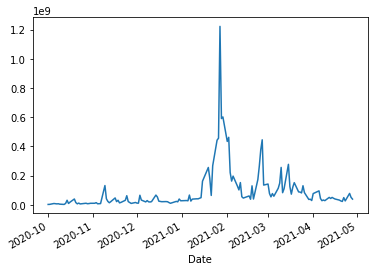

NOK
[*********************100%***********************]  1 of 1 completed
            Open  High   Low  Close  Adj Close    Volume
Date                                                    
2020-10-01  3.91  3.92  3.84   3.87       3.87  17028000
2020-10-02  3.80  3.86  3.80   3.82       3.82  19307700
2020-10-05  3.95  3.96  3.88   3.93       3.93  15811400
2020-10-06  3.98  4.00  3.87   3.91       3.91  23824300
2020-10-07  3.90  3.92  3.86   3.90       3.90  15216500
...          ...   ...   ...    ...        ...       ...
2021-04-22  4.20  4.23  4.16   4.16       4.16  30173600
2021-04-23  4.16  4.20  4.12   4.20       4.20  24054100
2021-04-26  4.21  4.23  4.17   4.20       4.20  33928800
2021-04-27  4.20  4.23  4.17   4.22       4.22  29219000
2021-04-28  4.26  4.30  4.19   4.20       4.20  30467300

[144 rows x 6 columns]


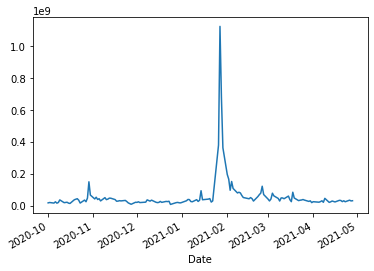

TSLA
[*********************100%***********************]  1 of 1 completed
                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2020-10-01  440.760010  448.880005  ...  448.160004  50741500
2020-10-02  421.390015  439.130005  ...  415.089996  71430000
2020-10-05  423.350006  433.640015  ...  425.679993  44722800
2020-10-06  423.790009  428.779999  ...  413.980011  49146300
2020-10-07  419.869995  429.899994  ...  425.299988  43127700
...                ...         ...  ...         ...       ...
2021-04-22  741.500000  753.770020  ...  719.690002  35590300
2021-04-23  719.799988  737.359985  ...  729.400024  28370000
2021-04-26  741.000000  749.299988  ...  738.200012  31038500
2021-04-27  717.960022  724.000000  ...  704.739990  29437000
2021-04-28  696.409973  708.500000  ...  694.400024  22271000

[144 rows x 6 columns]


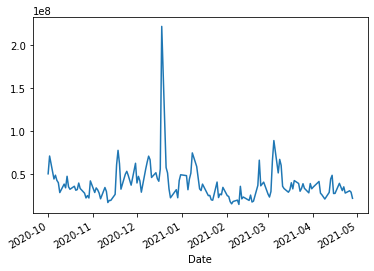

BB
[*********************100%***********************]  1 of 1 completed
            Open  High   Low  Close  Adj Close    Volume
Date                                                    
2020-10-01  4.59  4.64  4.52   4.58       4.58   4971200
2020-10-02  4.49  4.50  4.37   4.44       4.44   6539300
2020-10-05  4.46  4.51  4.43   4.50       4.50   3106300
2020-10-06  4.53  4.68  4.51   4.55       4.55   3966000
2020-10-07  4.60  4.64  4.52   4.57       4.57   2166900
...          ...   ...   ...    ...        ...       ...
2021-04-22  8.69  8.97  8.58   8.64       8.64   8636300
2021-04-23  8.66  8.88  8.59   8.85       8.85   5426100
2021-04-26  8.86  9.19  8.84   9.09       9.09   8168100
2021-04-27  9.16  9.62  8.87   9.29       9.29  21110700
2021-04-28  9.23  9.67  9.12   9.30       9.30  12299900

[144 rows x 6 columns]


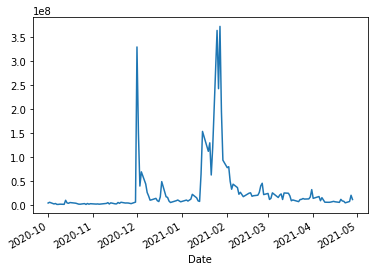

KOSS
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2020-10-01   2.140000   2.180000   2.010000   2.170000   2.170000    10000
2020-10-02   2.170000   2.170000   2.170000   2.170000   2.170000      200
2020-10-05   2.140000   2.180000   2.130000   2.150000   2.150000     8500
2020-10-06   2.170000   2.210000   2.150000   2.150000   2.150000     9300
2020-10-07   2.160000   2.230000   2.160000   2.200000   2.200000     6900
...               ...        ...        ...        ...        ...      ...
2021-04-22  19.620001  19.620001  18.600000  19.170000  19.170000   439200
2021-04-23  19.219999  19.270000  18.730000  18.799999  18.799999   261500
2021-04-26  18.799999  21.490000  18.799999  20.240000  20.240000  1825700
2021-04-27  20.570000  21.500000  19.580000  19.790001  19.790001   746300
2021-04-28  19.870001  19.

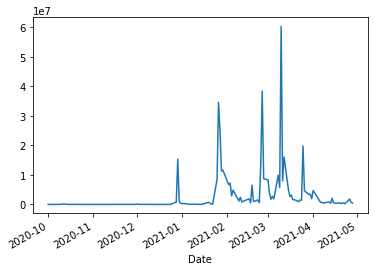

EXPR
[*********************100%***********************]  1 of 1 completed
            Open  High   Low  Close  Adj Close    Volume
Date                                                    
2020-10-01  0.62  0.84  0.62   0.80       0.80  17630000
2020-10-02  0.75  0.86  0.72   0.82       0.82   8230100
2020-10-05  0.80  0.85  0.76   0.76       0.76   3495900
2020-10-06  0.78  0.79  0.64   0.66       0.66   6800500
2020-10-07  0.70  0.76  0.69   0.70       0.70   5911300
...          ...   ...   ...    ...        ...       ...
2021-04-22  3.21  3.34  3.09   3.15       3.15   3114600
2021-04-23  3.17  3.20  3.09   3.15       3.15   1619000
2021-04-26  3.19  3.40  3.18   3.21       3.21   3955700
2021-04-27  3.26  3.47  3.16   3.26       3.26   3710600
2021-04-28  3.25  3.30  3.13   3.28       3.28   2169200

[144 rows x 6 columns]


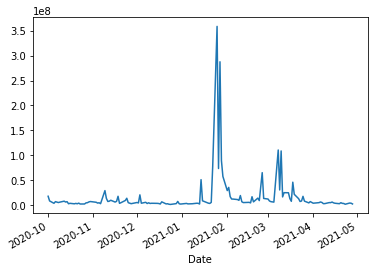

FB
[*********************100%***********************]  1 of 1 completed
                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2020-10-01  265.350006  268.329987  ...  266.630005  20009800
2020-10-02  261.209991  265.149994  ...  259.940002  16367600
2020-10-05  262.200012  264.869995  ...  264.649994  12822300
2020-10-06  261.779999  265.690002  ...  258.660004  18696900
2020-10-07  259.209991  260.179993  ...  258.119995  23133400
...                ...         ...  ...         ...       ...
2021-04-22  301.329987  302.920013  ...  296.519989  16375400
2021-04-23  298.760010  302.589996  ...  301.130005  17536800
2021-04-26  303.339996  305.799988  ...  303.040009  16172600
2021-04-27  304.279999  305.339996  ...  303.570007  15309300
2021-04-28  307.359985  310.920013  ...  307.100006  33907200

[144 rows x 6 columns]


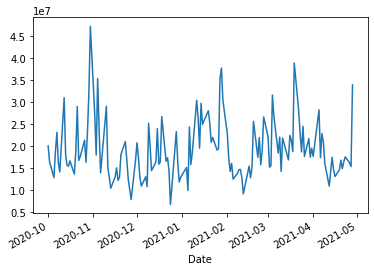

MSFT
[*********************100%***********************]  1 of 1 completed
                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2020-10-01  213.490005  213.990005  ...  211.418289  27158400
2020-10-02  208.000000  210.990005  ...  205.179031  33154800
2020-10-05  207.220001  210.410004  ...  209.348495  21331600
2020-10-06  208.820007  210.179993  ...  204.900406  28554300
2020-10-07  207.059998  210.110001  ...  208.801178  25681100
...                ...         ...  ...         ...       ...
2021-04-22  260.209991  261.779999  ...  257.170013  25606200
2021-04-23  257.880005  261.510010  ...  261.149994  21462600
2021-04-26  261.660004  262.440002  ...  261.549988  19763300
2021-04-27  261.579987  263.190002  ...  261.970001  31014200
2021-04-28  256.079987  256.540009  ...  254.559998  46903100

[144 rows x 6 columns]


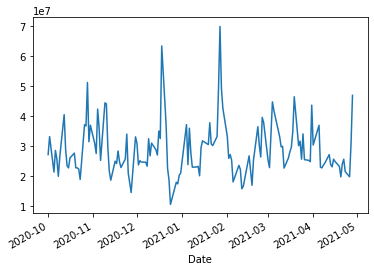

AMZN
[*********************100%***********************]  1 of 1 completed
                   Open         High  ...    Adj Close   Volume
Date                                  ...                      
2020-10-01  3208.000000  3224.000000  ...  3221.260010  4971900
2020-10-02  3153.629883  3195.800049  ...  3125.000000  5613100
2020-10-05  3145.840088  3202.530029  ...  3199.199951  3775300
2020-10-06  3165.000000  3182.000000  ...  3099.959961  5086900
2020-10-07  3135.000000  3200.000000  ...  3195.689941  4309400
...                 ...          ...  ...          ...      ...
2021-04-22  3371.679932  3372.870117  ...  3309.040039  2580600
2021-04-23  3319.100098  3375.000000  ...  3340.879883  3192800
2021-04-26  3348.000000  3428.449951  ...  3409.000000  4880700
2021-04-27  3443.469971  3460.000000  ...  3417.429932  3827100
2021-04-28  3434.800049  3489.879883  ...  3458.500000  4631900

[144 rows x 6 columns]


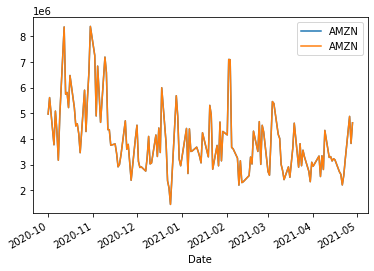

NFLX
[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close   Volume
Date                                                                           
2020-10-01  506.029999  529.549988  503.600006  527.510010  527.510010  8153700
2020-10-02  516.429993  526.369995  502.700012  503.059998  503.059998  6071200
2020-10-05  506.799988  520.989990  501.700012  520.650024  520.650024  4088100
2020-10-06  518.719971  521.820007  504.160004  505.869995  505.869995  4199000
2020-10-07  518.000000  536.489990  515.820007  534.659973  534.659973  7988700
...                ...         ...         ...         ...         ...      ...
2021-04-22  513.820007  513.960022  500.549988  508.779999  508.779999  9061100
2021-04-23  509.010010  509.700012  500.700012  505.549988  505.549988  7307700
2021-04-26  506.760010  510.480011  503.000000  510.299988  510.299988  4388800
2021-04-27  512.619995  512.989990  504.579987

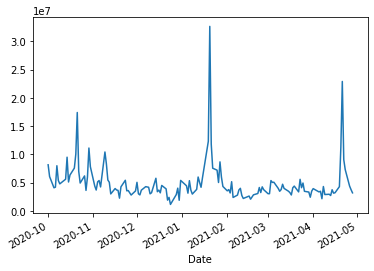

GOOGL
[*********************100%***********************]  1 of 1 completed
                   Open         High  ...    Adj Close   Volume
Date                                  ...                      
2020-10-01  1483.660034  1495.069946  ...  1487.900024  1644200
2020-10-02  1459.630005  1479.030029  ...  1455.599976  1561100
2020-10-05  1462.650024  1484.699951  ...  1482.829956  1080100
2020-10-06  1475.500000  1484.520020  ...  1451.020020  1304800
2020-10-07  1459.310059  1468.969971  ...  1459.140015  1805400
...                 ...          ...  ...          ...      ...
2021-04-22  2275.399902  2288.879883  ...  2252.520020  1207300
2021-04-23  2267.000000  2306.120117  ...  2299.929932  1453300
2021-04-26  2304.520020  2324.530029  ...  2309.929932  1601900
2021-04-27  2317.629883  2318.449951  ...  2290.979980  2219300
2021-04-28  2392.500000  2431.379883  ...  2359.040039  4055300

[144 rows x 6 columns]


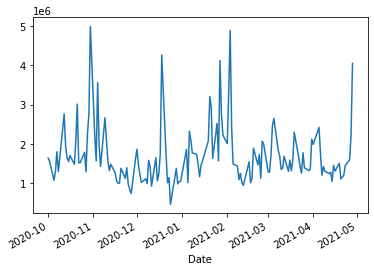

BABA
[*********************100%***********************]  1 of 1 completed
                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2020-10-01  295.260010  295.589996  ...  290.049988  16304000
2020-10-02  286.619995  291.979004  ...  288.170013  11482800
2020-10-05  289.059998  290.000000  ...  288.269989  17876400
2020-10-06  287.410004  296.839996  ...  292.390015  15860400
2020-10-07  297.989990  299.510010  ...  296.500000  16669300
...                ...         ...  ...         ...       ...
2021-04-22  228.764999  234.000000  ...  229.350006  11986200
2021-04-23  230.649994  233.000000  ...  232.080002   8967000
2021-04-26  231.500000  233.490005  ...  232.699997   7792900
2021-04-27  233.440002  236.929993  ...  235.919998  11646300
2021-04-28  237.570007  239.220001  ...  236.720001   9187700

[144 rows x 6 columns]


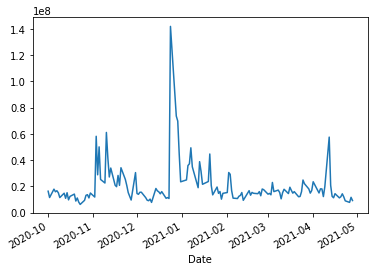

AAPL
[*********************100%***********************]  1 of 1 completed
                  Open        High  ...   Adj Close     Volume
Date                                ...                       
2020-10-01  117.639999  117.720001  ...  116.217491  116120400
2020-10-02  112.889999  115.370003  ...  112.465973  144712000
2020-10-05  113.910004  116.650002  ...  115.928909  106243800
2020-10-06  115.699997  116.120003  ...  112.605286  161498200
2020-10-07  114.620003  115.550003  ...  114.515877   96849000
...                ...         ...  ...         ...        ...
2021-04-22  133.039993  134.149994  ...  131.716278   84566500
2021-04-23  132.160004  135.119995  ...  134.092239   78657500
2021-04-26  134.830002  135.059998  ...  134.491562   66905100
2021-04-27  135.009995  135.410004  ...  134.162109   66015800
2021-04-28  134.309998  135.020004  ...  133.353485  107760100

[144 rows x 6 columns]


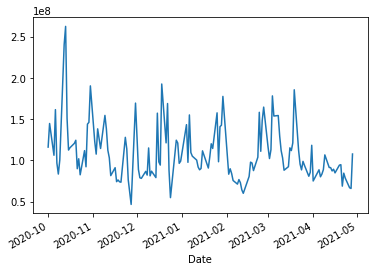

AMZN
[*********************100%***********************]  1 of 1 completed
                   Open         High  ...    Adj Close   Volume
Date                                  ...                      
2020-10-01  3208.000000  3224.000000  ...  3221.260010  4971900
2020-10-02  3153.629883  3195.800049  ...  3125.000000  5613100
2020-10-05  3145.840088  3202.530029  ...  3199.199951  3775300
2020-10-06  3165.000000  3182.000000  ...  3099.959961  5086900
2020-10-07  3135.000000  3200.000000  ...  3195.689941  4309400
...                 ...          ...  ...          ...      ...
2021-04-22  3371.679932  3372.870117  ...  3309.040039  2580600
2021-04-23  3319.100098  3375.000000  ...  3340.879883  3192800
2021-04-26  3348.000000  3428.449951  ...  3409.000000  4880700
2021-04-27  3443.469971  3460.000000  ...  3417.429932  3827100
2021-04-28  3434.800049  3489.879883  ...  3458.500000  4631900

[144 rows x 6 columns]


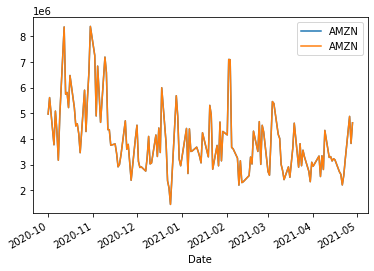

RCL
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2020-10-01  65.150002  65.919998  63.570000  65.550003  65.550003  5432000
2020-10-02  62.500000  65.760002  62.299999  65.260002  65.260002  4949000
2020-10-05  65.000000  66.099998  64.500000  65.250000  65.250000  3575800
2020-10-06  66.000000  69.910004  65.769997  66.180000  66.180000  7355400
2020-10-07  67.470001  68.639999  66.099998  68.019997  68.019997  4551400
...               ...        ...        ...        ...        ...      ...
2021-04-22  84.400002  86.550003  83.610001  84.180000  84.180000  2982200
2021-04-23  84.650002  85.959999  83.279999  85.809998  85.809998  2512100
2021-04-26  87.400002  88.839996  86.669998  86.940002  86.940002  2229500
2021-04-27  87.010002  88.220001  85.820000  87.629997  87.629997  2112200
2021-04-28  87.260002  88.4

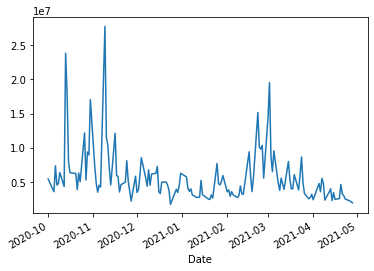

AAL
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2020-10-01  12.450000  12.770000  12.350000  12.580000  12.580000   48842000
2020-10-02  12.050000  13.350000  12.000000  13.000000  13.000000  111883300
2020-10-05  13.090000  13.200000  12.750000  13.120000  13.120000   53465500
2020-10-06  13.280000  13.440000  12.460000  12.530000  12.530000   85252400
2020-10-07  12.980000  13.180000  12.810000  13.070000  13.070000   61274200
...               ...        ...        ...        ...        ...        ...
2021-04-22  21.580000  21.610001  20.040001  20.070000  20.070000   72635100
2021-04-23  20.270000  21.200001  20.180000  21.110001  21.110001   47995300
2021-04-26  21.520000  22.049999  21.480000  22.040001  22.040001   44349200
2021-04-27  22.010000  22.070000  21.600000  21.760000  21.760000   26767100
202

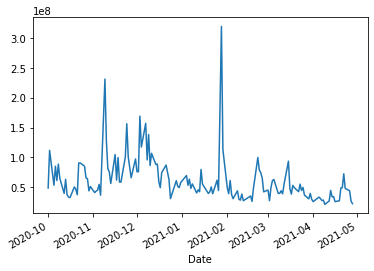

BA
[*********************100%***********************]  1 of 1 completed
                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2020-10-01  170.149994  172.759995  ...  167.860001  30677100
2020-10-02  161.860001  169.779999  ...  168.080002  31773800
2020-10-05  169.490005  172.080002  ...  171.199997  19082100
2020-10-06  173.039993  175.559998  ...  159.539993  47132500
2020-10-07  163.710007  166.339996  ...  164.610001  26019100
...                ...         ...  ...         ...       ...
2021-04-22  235.960007  239.649994  ...  234.330002  13854400
2021-04-23  233.889999  238.580002  ...  238.380005  11533100
2021-04-26  240.240005  244.649994  ...  241.440002  10599600
2021-04-27  241.880005  243.490005  ...  242.470001  10583300
2021-04-28  239.000000  239.649994  ...  235.460007  19054100

[144 rows x 6 columns]


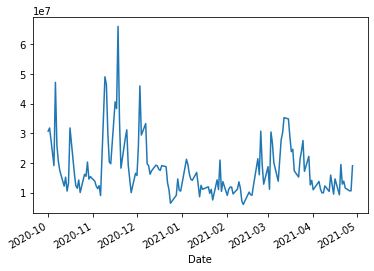

ZM
[*********************100%***********************]  1 of 1 completed
                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2020-10-01  477.000000  483.730011  ...  482.989990   7859300
2020-10-02  485.005005  507.489990  ...  482.230011  12791700
2020-10-05  493.970001  496.899994  ...  485.369995   7534700
2020-10-06  480.510010  487.899994  ...  478.250000   6097700
2020-10-07  482.500000  487.500000  ...  480.609985   4449500
...                ...         ...  ...         ...       ...
2021-04-22  322.665009  338.049988  ...  328.320007   3328300
2021-04-23  331.489990  338.549988  ...  336.880005   2454300
2021-04-26  337.510010  338.000000  ...  336.420013   2286700
2021-04-27  336.390015  341.679993  ...  333.489990   2208300
2021-04-28  330.239990  334.700989  ...  331.250000   1437600

[144 rows x 6 columns]


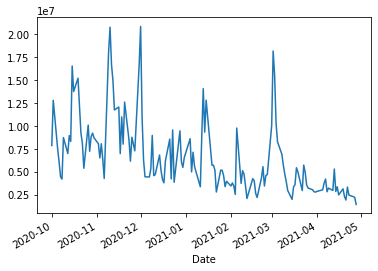

MRNA
[*********************100%***********************]  1 of 1 completed
                  Open        High  ...   Adj Close    Volume
Date                                ...                      
2020-10-01   69.570000   70.199997  ...   70.029999   6839000
2020-10-02   67.900002   72.769997  ...   68.809998   8004900
2020-10-05   69.639999   72.019997  ...   71.949997   6518100
2020-10-06   72.000000   73.919998  ...   71.040001   7285500
2020-10-07   71.230003   73.239998  ...   72.370003   4190600
...                ...         ...  ...         ...       ...
2021-04-22  168.259995  179.000000  ...  168.100006  15922400
2021-04-23  170.304993  175.509995  ...  173.630005   8791000
2021-04-26  171.789993  179.600006  ...  177.610001  12201700
2021-04-27  178.360001  185.529999  ...  183.410004  12925700
2021-04-28  182.369995  182.889999  ...  178.679993   8375400

[144 rows x 6 columns]


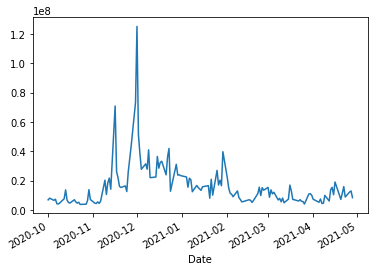

BYND
[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close   Volume
Date                                                                           
2020-10-01  169.240005  172.690002  165.880005  170.600006  170.600006  4729200
2020-10-02  165.589996  171.750000  164.809998  166.240005  166.240005  2949000
2020-10-05  168.649994  175.889999  166.759003  175.490005  175.490005  4163200
2020-10-06  176.229996  186.699997  175.000000  181.860001  181.860001  8478800
2020-10-07  184.649994  191.600006  184.199997  189.139999  189.139999  5167900
...                ...         ...         ...         ...         ...      ...
2021-04-22  133.729996  136.619995  132.160004  132.830002  132.830002  1558400
2021-04-23  133.039993  134.880005  130.899994  131.419998  131.419998  1812700
2021-04-26  132.119995  132.899994  129.509995  132.059998  132.059998  1962000
2021-04-27  131.843994  134.199997  131.550003

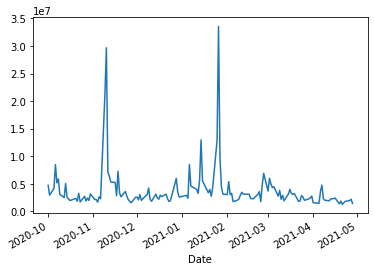

CCL
[*********************100%***********************]  1 of 1 completed
                 Open       High        Low      Close  Adj Close    Volume
Date                                                                       
2020-10-01  15.430000  15.430000  14.700000  15.030000  15.030000  28158400
2020-10-02  14.260000  15.220000  14.230000  15.160000  15.160000  30936100
2020-10-05  15.110000  15.230000  14.800000  14.960000  14.960000  22169300
2020-10-06  15.260000  15.970000  15.120000  15.190000  15.190000  43724300
2020-10-07  15.480000  16.049999  15.290000  15.990000  15.990000  30265000
...               ...        ...        ...        ...        ...       ...
2021-04-22  26.969999  27.900000  26.770000  26.910000  26.910000  29698400
2021-04-23  27.000000  27.410000  26.570000  27.270000  27.270000  19297600
2021-04-26  27.820000  28.500000  27.309999  27.549999  27.549999  20033500
2021-04-27  27.590000  27.879999  27.139999  27.809999  27.809999  18145200
2021-04-28  27.

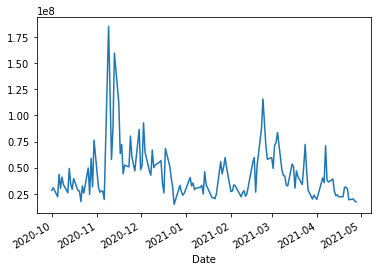

                   GME    AMC   NOK  ...        MRNA        BYND        CCL
Date                                 ...                                   
2020-10-01    9.770000   4.65  3.87  ...   70.029999  170.600006  15.030000
2020-10-02    9.390000   4.65  3.82  ...   68.809998  166.240005  15.160000
2020-10-05    9.460000   4.13  3.93  ...   71.949997  175.490005  14.960000
2020-10-06    9.130000   4.06  3.91  ...   71.040001  181.860001  15.190000
2020-10-07    9.360000   4.04  3.90  ...   72.370003  189.139999  15.990000
...                ...    ...   ...  ...         ...         ...        ...
2021-04-22  151.169998   9.99  4.16  ...  168.100006  132.830002  26.910000
2021-04-23  151.179993  10.16  4.20  ...  173.630005  131.419998  27.270000
2021-04-26  168.929993  11.50  4.20  ...  177.610001  132.059998  27.549999
2021-04-27  177.770004  11.46  4.22  ...  183.410004  133.500000  27.809999
2021-04-28  178.580002  10.85  4.20  ...  178.679993  134.220001  27.799999

[144 rows x

In [ ]:
# Get the data for all stocks
companies = ['GME' , 'AMC', 'NOK', 'TSLA', 'BB', 'KOSS', 'EXPR', 'FB', 'MSFT', 'AMZN', 'NFLX', 'GOOGL', 'BABA', 'AAPL', 'AMZN', 'RCL', 'AAL', 'BA', 'ZM', 'MRNA', 'BYND', 'CCL']
closing = pd.DataFrame([], columns = companies)
trading = pd.DataFrame([], columns = companies)
percentage = pd.DataFrame([], columns = companies)

for company in companies:
  data = yf.download(company,'2020-10-01','2021-04-29') # Download data in timeframe

  # Save wanted data
  closing[company] = data['Adj Close']
  percentage[company] = (data['Adj Close'] - data['Open']) / data['Open'] * 100
  trading[company] = data['Volume']

  # Plot the close price of the company
  trading[company].plot()
  plt.show()

print(closing)
# Export Closing Prices
filename = r"/content/drive/Shareddrives/COS424/closing.csv"
closing.to_csv(filename, index=True)

# Export Trading Volumes
filename = r"/content/drive/Shareddrives/COS424/trading.csv"
trading.to_csv(filename, index=True)

# Export Percentage Price Changes
filename = r"/content/drive/Shareddrives/COS424/percent.csv"
percentage.to_csv(filename, index=True)

# Bag of Words

In [ ]:
# Read in Cleaned Reddit or Google News Data for Bag of Words Creation

reddit = r"/content/drive/Shareddrives/COS424/RedditAllBigClean.csv" # alternative: Google News
reddit_df = pd.read_csv(reddit)
reddit_df['date']=pd.to_datetime(reddit_df['est'])
reddit_df['date']=pd.DatetimeIndex(reddit_df.date).normalize()
reddit_df=reddit_df.set_index(reddit_df['date'])
reddit_df=reddit_df.fillna('The')

compName = ['GME', 'AMC', 'NOK', 'TSLA', 'BB', 'KOSS', 'EXPR',
          'MSFT', 'FB', 'AMZN', 'GOOGL', 'AAPL', 'NFLX', 'BABA',
        'RCL', 'CCL', 'BY', 'ZM', 'AAL', 'BA', 'MRNA']

compType = ['Hype', 'Hype', 'Hype', 'Hype', 'Hype', 'Hype', 'Hype',
            'Lead', 'Lead', 'Lead', 'Lead', 'Lead', 'Lead', 'Lead',
            'Volat', 'Volat', 'Volat', 'Volat', 'Volat', 'Volat', 'Volat']

# Create bag df
reddit_bag = pd.DataFrame(columns=['Title','Body','Company','Date'])

# For every company and every day create individual bag of words df
for company in compName:
  df = reddit_df[reddit_df.company == company]

  bag = pd.DataFrame(columns=['Title','Body','Company','Date'])
  dates = pd.date_range(start="2020-10-01",end="2021-04-29")
  bag['Date']=dates
  bag=bag.set_index(bag['Date'])
  
  # for every day, find all posts or headlines for that day and append them to each other
  for date in dates:
    bag.at[date,'Company']=company

    if date in df.index:


      title = df.loc[[date],['titleClean']]
      stringTitle=""
      for i in range(len(title)):
        string=title.iloc[i, 0]
        stringTitle += string
        
      body = df.loc[[date],['bodyClean']]
      stringBody=""
      for i in range(len(body)):
        string=body.iloc[i, 0]
        stringBody += string
      bag.at[date,'Title']=stringTitle
      bag.at[date,'Body']=stringBody
      
    else: 
      #if no posts or headlines for that day, fill with filler word "the"
      bag.at[date,'Title']='the'
      bag.at[date,'Body']='the'
    
  new = new.append(bag) # new includes all bag of words, ready for vectorization

In [ ]:
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html 
from sklearn.feature_extraction.text import TfidfVectorizer

# Uses a TfidfVectorizer to construct bag-of-words matrix
vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=1000) # for SVC

# create separate bag-of-word representations for Reddit post title and bodies
r_body = vectorizer.fit_transform(new['Body'])
r_title = vectorizer.fit_transform(new['Title'])

# create bag of word representation of Google news headline (if applicable)
r_news= vectorizer.fit_transform(new['Body'])


# Prediction

## Neural

To run the neural network, please first run this section before going to "Main Predictor" and running with the wanted settings.

In [ ]:
# The code in this section is adapted from T. Davidson's neural network: https://github.com/t-davidson/fragile-families-challenge/blob/master/preprocess/clean_files.py
def make_model(activation_function, num_hidden_layers, hidden_layer_size): 
  model = Sequential()

    # Single layer model
  if num_hidden_layers == 0: # then just specify a single layer, 1 is size of output
        model.add(Dense(1, 
                        input_dim=X_train.shape[1], 
                        activation=activation_function,
                        use_bias=True))
        model.add(Dropout(0.5))
    
    # Specify initial layer with a hidden layer
  if num_hidden_layers >= 1: 
        model.add(Dense(hidden_layer_size, 
                        input_dim=X_train.shape[1], 
                        activation=activation_function,
                        use_bias=True))
        model.add(Dropout(0.5))
    
    # Now add additional hidden layers
  for i in range(0,num_hidden_layers-1):
        model.add(Dense(hidden_layer_size, 
                        activation=activation_function, 
                        use_bias=True))
        model.add(Dropout(0.5))
    
  if num_hidden_layers > 0:       
        model.add(Dense(1)) # Final output layer, don't add if no hidden layers

  model.compile(loss='mean_squared_error',
                  optimizer='adam')
  return model

In [ ]:
# Set to 100 epochs and set parameters
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score, KFold
from keras.models import Sequential
from sklearn.metrics import accuracy_score
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
model = KerasRegressor(make_model, batch_size=32, epochs=100)

# Choose wanted parameters for CrossValidation (might take several hours to run)
params = [{'num_hidden_layers': [0],
          'hidden_layer_size': [0],
          'activation_function': ['sigmoid', 'tanh']},
          {'num_hidden_layers': [1, 2, 3],
          'hidden_layer_size': [64, 128, 256],
          'activation_function': ['linear', 'sigmoid', 'tanh']}]

grid = GridSearchCV(model,
                        param_grid=params,
                        scoring='neg_mean_squared_error', #sklearn optimizing by maximizing negative MSE
                        n_jobs=1,
                        verbose=0,
                        cv=5 # Number of folds for CV
                  )

"   \nparams = [{'num_hidden_layers': [0],\n          'hidden_layer_size': [0],\n          'activation_function': ['sigmoid', 'tanh']},\n          {'num_hidden_layers': [1],\n          'hidden_layer_size': [64],\n          'activation_function': ['linear']}]\n"

## Lasso Feature Selection

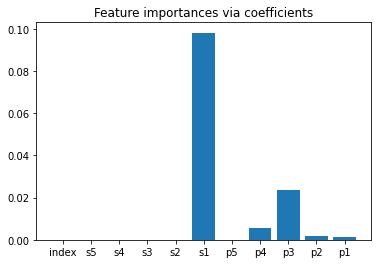

0.0 index
0.0 s5
0.0 s4
0.0 s3
0.0 s2
0.0981190765757166 s1
0.0 p5
0.005357651139734147 p4
0.023743481109756503 p3
0.0019060096320370264 p2
0.0013698972960457258 p1


In [ ]:
# Perform Feature Selection (note: first perform the train-test split in "Main Predictor")
lasso = LassoCV().fit(X_train, y_train)

# Print feature importances
importance = np.abs(lasso.coef_)
feature_names = np.array(X_train.columns)
plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

# Detailed feature importances
for i in range(0, len(importance)):
    print(str(importance[i]) + ' ' + feature_names[i])
    


## Main Predictor

In [ ]:
# CHOOSE OPTIONS BELOW BEFORE RUNNING:

gn = False # For Google News: True // For Reddit: False
all = False # For full dataset: True // For 2021 data only: False
numb = 80 # Days in training set: 80 (rest automatically test)
toModel = 'NN' # NN: Neural Network // LINREG: Logistic Regression
binary = False # Categorical or Continuous Prediction

# Read in wanted data
reddit = r"/content/drive/Shareddrives/COS424/reddit_compound_scores.csv"
df = pd.read_csv(reddit)

if not all:
  numb = 40

if gn:
  news = r"/content/drive/Shareddrives/COS424/news_compound_scores.csv"
  df = pd.read_csv(news)

stock = r"/content/drive/Shareddrives/COS424/percent.csv"
stocks = pd.read_csv(stock)
stocks['Date']= pd.to_datetime(stocks['Date'])
stocks['Date'] = [time.date() for time in stocks['Date']]

compName = ['GME', 'AMC', 'NOK', 'TSLA', 'BB', 'KOSS', 'EXPR',
            'MSFT', 'FB', 'AMZN', 'GOOGL', 'AAPL', 'NFLX', 'BABA',
            'RCL', 'CCL', 'BY', 'ZM', 'AAL', 'BA', 'MRNA']


compType = ['Hype', 'Hype', 'Hype', 'Hype', 'Hype', 'Hype', 'Hype',
            'Lead', 'Lead', 'Lead', 'Lead', 'Lead', 'Lead', 'Lead',
            'Volat', 'Volat', 'Volat', 'Volat', 'Volat', 'Volat', 'Volat']

# Fit model and predict prices for every single company in wanted interval
for company in compName:
  x = df.loc[df['company'] == company]

  # Adjust comapny name error
  if company == 'BY':
    company = 'BYND'
  x['date']= pd.to_datetime(x['date'])
  x['date'] = [time.date() for time in x['date']]
  x = x.set_index('date') # make dates column index

  # Remove dates not in wanted interval
  if all:
    prevDates = pd.date_range(start="2020-09-30", end='2020-09-30')
    dates = pd.date_range(start="2020-10-02",end="2021-04-29")
    date = datetime.strptime('01102020', "%d%m%Y").date()
  else:
    prevDates = pd.date_range(start="2020-09-30", end='2020-12-30')
    dates = pd.date_range(start="2021-01-01",end="2021-04-29")
    date = datetime.strptime('31122020', "%d%m%Y").date()

  # Fill out non-existent dates [CLEAN DATA]
  if date not in list(x.index.values):
    if gn:
      x.loc[date] = [0,0,0,0,0,0, company, 0]
    else:
      x.loc[date] = [0,0,0,0,0,0,0,0,0,0, company,0, 0]
  arr = []
  for date in prevDates:
     if date in list(x.index.values):
        x = x.drop(date)

  for date in prevDates:
     if date in list(stocks['Date'].values):
       stocks.drop( stocks[ stocks['Date'] == date ].index , inplace=True)
  
  for date in dates:
      date = date.date()
      if date not in list(x.index.values):
        if gn:
          x.loc[date] = [0,0,0,0,0,0, company, 0]
        else:
          x.loc[date] = [0,0,0,0,0,0,0,0,0,0, company, 0, 0]
  
  # ADJUST NO-TRADING DAYS, by taking weighted average
  for date in dates:
    date = date.date()
    if date not in stocks['Date'].values:
      arr.append(date - timedelta(days=1))
      # print(date)
    else:
      if len(arr) > 0:
        arr.append(date - timedelta(days=1))
        sum = 0
        num = 0
        neu = 0
        neg = 0
        pos = 0

        sumB = 0
        neuB = 0
        negB = 0
        posB = 0

        for days in arr:
          sum += x['sum'][days]
          num += x['num'][days]
          neu += x['neu'][days]
          neg += x['neg'][days]

          if not gn:
            sumB += x['sumB'][days]
            neuB += x['neuB'][days]
            negB += x['negB'][days]
            posB += x['posB'][days]
        sum = sum/len(arr)
        num = num/len(arr)
        neu = neu/len(arr)
        neg = neg/len(arr)
        sumB = sumB/len(arr)
        neuB = neuB/len(arr)
        negB = negB/len(arr)
        posB = posB/len(arr)
        arr.remove(date - timedelta(days=1))
        x = x.drop(labels=arr, axis=0)
        x['sum'][date - timedelta(days=1)] = sum
        x['num'][date - timedelta(days=1)] = num
        x['pos'][date - timedelta(days=1)] = pos
        x['neu'][date - timedelta(days=1)] = neu
        x['neg'][date - timedelta(days=1)] = neg
        if not gn:
          x['sumB'][date - timedelta(days=1)] = sumB
          x['posB'][date - timedelta(days=1)] = posB
          x['neuB'][date - timedelta(days=1)] = neuB
          x['negB'][date - timedelta(days=1)] = negB
      arr = []
  print(company)

  # PREPARE DF FOR FITTING AND PREDICTION
  X = x.copy()
  if company == 'BY':
    Y = stocks['BYND']
  else:
    Y = stocks[company]
  
  

  X = X.reset_index()
  X = X.drop(df.index[0])
  X = X.drop('Unnamed: 0', axis=1)
  X = X.reset_index()
  X = X.drop('date', axis=1)
  X = X.drop('company', axis=1)
  Y = Y.reset_index()

  # Choose wante features (tuned from feature selection)
  columns = ['s5', 's4', 's3', 's2', 's1', 'p5', 'p4', 'p3', 'p2', 'p1', 'p']
  newDf = pd.DataFrame([], columns = columns)

  v = 'pos' # Predict on positivity score
  # v = 'neu'
  # v = 'neg'
  
  # Create dataframe with last 5 days of data(optional: add more features)
  for i in range(5, (len(Y) - 1)):
    act = [[  X[v][i-5], X[v][i-4], X[v][i-3], X[v][i-2], X[v][i-1],
         #  X[v2][i-5], X[v2][i-4], X[v2][i-3], X[v2][i-2], X[v2][i-1], 
           #  X[v3][i-5], X[v3][i-4], X[v3][i-3], X[v3][i-2], X[v3][i-1], 
            Y[company][i-5], Y[company][i-4],Y[company][i-3], Y[company][i-2], Y[company][i-1], 
            Y[company][i]]]
    row = pd.DataFrame(act, columns = columns)
    newDf = newDf.append(row)
  
  newDf = newDf.reset_index()
  # print(newDf)
  
  if binary:
    newDf.loc[(newDf.p >= 0),'p'] = 1
    newDf.loc[(newDf.p < 0), 'p'] = 0
  
  X_train = newDf.drop('p', axis=1).iloc[0:numb]
  y_train = newDf['p'].iloc[0:numb]
  X_test = newDf.drop('p', axis=1).iloc[numb:]
  y_test = newDf['p'].iloc[numb:]

  # FIT MODEL BASED ON CHOICE ('toModel')

  # Neural Network
  if toModel == 'NN':
    model = KerasRegressor(make_model, batch_size=32, epochs=100)
    params = [{'num_hidden_layers': [1, 2],
              'hidden_layer_size': [64, 128],
              'activation_function': ['linear', 'sigmoid', 'tanh']}]
    grid = GridSearchCV(model,
                        param_grid=params,
                        scoring='neg_mean_squared_error', #sklearn optimizing by maximizing negative MSE
                        n_jobs=1,
                        verbose=0,
                        cv=5 )
  

  # Logistic Regression
  elif toModel == 'LOGREG':
    parameters = {'solver':('newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga')}
    grid = GridSearchCV(LogisticRegression(), parameters)

  # Linear Regression
  elif toModel == 'LINREG':
    linreg = LinearRegression()
    lin_params = [{'fit_intercept': [True, False], 'normalize': [True, False]}]

    # Perform Grid Search
    grid = GridSearchCV(linreg,
                            param_grid=lin_params,
                            scoring='neg_mean_squared_error', #sklearn optimizing by maximizing negative MSE
                            n_jobs=1,
                            verbose=0,
                            cv=5)
  
  # SVC
  elif toModel == 'SVC':
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svc = svm.SVC()
    grid = GridSearchCV(svc, parameters)


  # Fit and Run chosen Model
  grid.fit(np.array(X_train), np.array(y_train))
  best_model = grid.best_estimator_ #scikit-wrapped best model
  # print(best_model) # optional
  prediction = best_model.predict(X_test)
  
  # Turn predictions into binary
  b = (prediction > 0).astype(int)
  # print(b)
  c = (y_test > 0).astype(int)
  # print(c)
  direction = ((b-c) == 0)

  # PRINT OUT PERCENT ACCURACY FOR GIVEN STOCK
  if ((b-c) == 0).unique()[0] == True:
    print(list(Counter(direction).values())[0]/len(direction))
  else:
    print(list(Counter(direction).values())[1]/len(direction))

GME
0.4
AMC
0.3142857142857143
NOK
0.37142857142857144
TSLA
0.5714285714285714
BB
0.45714285714285713
KOSS
0.3142857142857143
EXPR
0.45714285714285713
MSFT
0.5428571428571428
FB
0.5428571428571428
AMZN
0.6285714285714286
GOOGL
0.5428571428571428
AAPL
0.4857142857142857
NFLX
0.6
BABA
0.6
RCL
0.45714285714285713
CCL
0.42857142857142855
BYND
0.4
ZM
0.5428571428571428
AAL
0.4
BA
0.4857142857142857
MRNA
0.6


## Ensemble

Note this section was not finished in time, but can be used as a base to construct an ensemble model as suggestion in the "Discussion Section" of our paper.

In [ ]:

# CHOOSE OPTIONS BELOW BEFORE RUNNING
gn = False # For Google News: True // For Reddit: False
all = False # For full dataset: True // For 2021 data only: False
numb = 80 # Days in training set: 80 (rest automatically test)
toModel = 'LINREG' # NN: Neural Network // LINREG: Logistic Regression
binary = False
reddit = r"/content/drive/Shareddrives/COS424/reddit_compound_scores.csv"
df = pd.read_csv(reddit)

if not all:
  numb = 40

if gn:
  news = r"/content/drive/Shareddrives/COS424/news_compound_scores.csv"
  df = pd.read_csv(news)

stock = r"/content/drive/Shareddrives/COS424/trading.csv"
stocks = pd.read_csv(stock)
stocks['Date']= pd.to_datetime(stocks['Date'])
stocks['Date'] = [time.date() for time in stocks['Date']]
# print(stocks['Date'])

compName = ['GME', 'AMC', 'NOK', 'TSLA', 'BB', 'KOSS', 'EXPR',
            'MSFT', 'FB', 'AMZN', 'GOOGL', 'AAPL', 'NFLX', 'BABA',
            'RCL', 'CCL', 'BY', 'ZM', 'AAL', 'BA', 'MRNA']

# compName = ['MSFT']

compType = ['Hype', 'Hype', 'Hype', 'Hype', 'Hype', 'Hype', 'Hype',
            'Lead', 'Lead', 'Lead', 'Lead', 'Lead', 'Lead', 'Lead',
            'Volat', 'Volat', 'Volat', 'Volat', 'Volat', 'Volat', 'Volat']

for company in compName:
  x = df.loc[df['company'] == company]
  if company == 'BY':
    company = 'BYND'
  x['date']= pd.to_datetime(x['date'])
  x['date'] = [time.date() for time in x['date']]
  x = x.set_index('date') # make dates column index

  if all:
    prevDates = pd.date_range(start="2020-09-30", end='2020-09-30')
    dates = pd.date_range(start="2020-10-02",end="2021-04-29")
    date = datetime.strptime('01102020', "%d%m%Y").date()
  else:
    prevDates = pd.date_range(start="2020-09-30", end='2020-12-30')
    dates = pd.date_range(start="2021-01-01",end="2021-04-29")
    date = datetime.strptime('31122020', "%d%m%Y").date()

  if date not in list(x.index.values):
    if gn:
      x.loc[date] = [0,0,0,0,0,0, company, 0]
    else:
      x.loc[date] = [0,0,0,0,0,0,0,0,0,0, company,0, 0]
  arr = []
  for date in prevDates:
     if date in list(x.index.values):
        x = x.drop(date)

  for date in prevDates:
     if date in list(stocks['Date'].values):
       stocks.drop( stocks[ stocks['Date'] == date ].index , inplace=True)
  
  for date in dates:
      date = date.date()
      if date not in list(x.index.values):
        if gn:
          x.loc[date] = [0,0,0,0,0,0, company, 0]
        else:
          x.loc[date] = [0,0,0,0,0,0,0,0,0,0, company, 0, 0]
  
  # print(stocks['Date'].values)
  for date in dates:
    date = date.date()
    if date not in stocks['Date'].values:
      arr.append(date - timedelta(days=1))
      # print(date)
    else:
      if len(arr) > 0:
        arr.append(date - timedelta(days=1))
        sum = 0
        num = 0
        neu = 0
        neg = 0
        pos = 0

        sumB = 0
        neuB = 0
        negB = 0
        posB = 0

        for days in arr:
          sum += x['sum'][days]
          num += x['num'][days]
          neu += x['neu'][days]
          neg += x['neg'][days]

          if not gn:
            sumB += x['sumB'][days]
            neuB += x['neuB'][days]
            negB += x['negB'][days]
            posB += x['posB'][days]
        sum = sum/len(arr)
        num = num/len(arr)
        neu = neu/len(arr)
        neg = neg/len(arr)
        sumB = sumB/len(arr)
        neuB = neuB/len(arr)
        negB = negB/len(arr)
        posB = posB/len(arr)
        arr.remove(date - timedelta(days=1))
        x = x.drop(labels=arr, axis=0)
        x['sum'][date - timedelta(days=1)] = sum
        x['num'][date - timedelta(days=1)] = num
        x['pos'][date - timedelta(days=1)] = pos
        x['neu'][date - timedelta(days=1)] = neu
        x['neg'][date - timedelta(days=1)] = neg
        if not gn:
          x['sumB'][date - timedelta(days=1)] = sumB
          x['posB'][date - timedelta(days=1)] = posB
          x['neuB'][date - timedelta(days=1)] = neuB
          x['negB'][date - timedelta(days=1)] = negB
      arr = []
  print(company)

  X = x.copy()
  if company == 'BY':
    Y = stocks['BYND']
  else:
    Y = stocks[company]
  
  

  X = X.reset_index()
  X = X.drop(df.index[0])
  X = X.drop('Unnamed: 0', axis=1)
  X = X.reset_index()
  X = X.drop('date', axis=1)
  X = X.drop('company', axis=1)
  Y = Y.reset_index()

  columns = ['s5', 's4', 's3', 's2', 's1', 'p5', 'p4', 'p3', 'p2', 'p1', 'p']
  columns = ['s5', 's4', 's3', 's2', 't1','t5', 't4', 't3', 't2', 't1', 'p5', 'p4', 'p3', 'p2', 'p1', 'p']

  # columns = ['s5', 's4', 's3', 's2', 's1', 'p5', 'p4', 'p3', 'p2', 'p1', 'p']
  v = 'avg'
  v2 = 'pos'
  v3 = 'neg'
 
  newDf = pd.DataFrame([], columns = columns)
  # newDf = pd.DataFrame([], columns = ['s1', 'p1', 'p'])

  for i in range(5, (len(Y) - 1)):
    act = [[X[v][i-5], X[v][i-4], X[v][i-3], X[v][i-2], X[v][i-1],
           X[v2][i-5], X[v2][i-4], X[v2][i-3], X[v2][i-2], X[v2][i-1], 
          #   X[v3][i-5], X[v3][i-4], X[v3][i-3], X[v3][i-2], X[v3][i-1], 
            Y[company][i-5], Y[company][i-4], Y[company][i-3], Y[company][i-2], Y[company][i-1], 
            Y[company][i]]]
    row = pd.DataFrame(act, columns = columns)
    newDf = newDf.append(row)
  
  newDf = newDf.reset_index()
  # print(newDf)
  
  if binary:
    newDf.loc[(newDf.p >= 0),'p'] = 1
    newDf.loc[(newDf.p < 0), 'p'] = 0
  
  X_train = newDf.drop('p', axis=1).iloc[0:numb]
  y_train = newDf['p'].iloc[0:numb]
  X_test = newDf.drop('p', axis=1).iloc[numb:]
  y_test = newDf['p'].iloc[numb:]

  if toModel == 'NN':
    model = KerasRegressor(make_model, batch_size=32, epochs=100)
    params = [{'num_hidden_layers': [1, 2],
              'hidden_layer_size': [64, 128],
              'activation_function': ['linear', 'sigmoid', 'tanh']}]
    grid = GridSearchCV(model,
                        param_grid=params,
                        scoring='neg_mean_squared_error', #sklearn optimizing by maximizing negative MSE
                        n_jobs=1,
                        verbose=0,
                        cv=5 )
    # print('The parameters of the best model are: ')
    # print(grid.best_params_)
    # print(grid.best_estimator_)

  elif toModel == 'SVC':
    parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
    svc = svm.SVC()
    grid = GridSearchCV(svc, parameters)

  # Fit and Run chosen Model
  grid.fit(np.array(X_train), np.array(y_train))
  best_model = grid.best_estimator_ #scikit-wrapped best model
  # print(best_model)
  prediction = best_model.predict(X_test)

  b = (prediction > 0).astype(int)
  # print(b)
  c = (y_test > 0).astype(int)
  # print(c)
  direction = ((b-c) == 0)

  if ((b-c) == 0).unique()[0] == True:
    print(list(Counter(direction).values())[0]/len(direction))
  else:
    print(list(Counter(direction).values())[1]/len(direction))

GME
0.8
AMC
0.8857142857142857
NOK
0.9428571428571428
TSLA
0.9714285714285714
BB
0.9142857142857143
KOSS
1.0
EXPR
1.0
MSFT
1.0
FB
1.0
AMZN
1.0
GOOGL
1.0
AAPL
1.0
NFLX
0.9714285714285714
BABA
1.0
RCL
1.0
CCL
1.0
BYND
1.0
ZM
1.0
AAL
1.0
BA
1.0
MRNA
1.0


In [ ]:
filename = r"/content/drive/Shareddrives/COS424/stocks.csv"
stocks.to_csv(filename)

# Scatter Plots

In [ ]:
# Create Scatter plots of correlation between stock price and sentiment or trading volumes

In [ ]:
scatter = pd.DataFrame([], columns = ['pred'])
scatter=pd.DataFrame()

# Choose X-Axis (from gme df - created in prediction)
scatter['a'] = gme['positive score']
x=scatter['a']

# Choose Y-Axis
scatter['b'] =gme['trading']

m, b = np.polyfit(x, scatter['b'], 1)
plt.plot(x, m*x + b)

plt.plot(x, scatter['b'], 'o', color='green')


# Granger Causality

In [ ]:
# read in stock data and match to sentiment data
filename = r"/content/drive/Shareddrives/COS424/percent.csv" 
stock = pd.read_csv(filename)

stock['Date']= pd.to_datetime(stock['Date'])
stock = trading.set_index('date')
for date in gme.index:
  if date in trading.index.values:
    gme.at[date,'stockPrice'] = stock.at[date,'GME']

In [ ]:
#source: https://rishi-a.github.io/2020/05/25/granger-causality.html
# for each sentiment score, compute Granger causality score between GME sentiment and stock 

labels = ['pos','comp','neu','neg']
for label in labels:
  newDF= pd.DataFrame()

  #shift data so it is stationary
  newDF[label] = gme[label] - gme[label].shift(1)
  newDF['stockPrice'] = gme['stockPrice'] - gme['stockPrice'].shift(1)
  newDF = newDF.dropna()


  # two tests to check for for stationarity

  ## ADF Null hypothesis: there is a unit root, meaning series is non-stationary
  from statsmodels.tsa.stattools import adfuller

  X1 = np.array(newDF[label])
  X1 = X1[~np.isnan(X1)]

  result = adfuller(X1)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))
      
      
  X2 = np.array(newDF['stockPrice'])
  X2 = X2[~np.isnan(X2)]

  result = adfuller(X2)
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
      print('\t%s: %.3f' % (key, value))

  ## KPSS Null hypothesis: there is a no unit root, meaning series is stationary
  from statsmodels.tsa.stattools import kpss
  def kpss_test(series, **kw):    
      statistic, p_value, n_lags, critical_values = kpss(series, **kw)
      # Format Output
      print(f'KPSS Statistic: {statistic}')
      print(f'p-value: {p_value}')
      print(f'num lags: {n_lags}')
      print('Critial Values:')
      for key, value in critical_values.items():
          print(f'   {key} : {value}')
      print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

  kpss_test(X1)
  kpss_test(X2)

  # perform granger causality
  stationary_df=pd.DataFrame(columns=['stock','sent'])
  stationary_df['stock']=X2
  stationary_df['sent']=X1
  print(label)
  res = grangercausalitytests(stationary_df, maxlag=5 )

# Extra Code

Extra code is mostly uncommented, because it is not used for any significant findings in our paper. It is included solely for convenience and to explore our process. It includes Flair Sentiment Analysis, bc we chose to go with VADER instead

## Graph Sentiment

In [ ]:
gme_df['weighted compound']=gme_df["comp"] * gme_df['score']
gme_df['weighted compound (body)']=gme_df["compB"] * gme_df['score']

In [ ]:
gme_df['date'] = pd.to_datetime(gme_df['est'],errors='coerce').dt.date

In [ ]:
names = ['date','daily score']
gme_time = pd.DataFrame(columns = names)
df.index = pd.to_datetime(df.index)

for row in gme_df.iterrows():
  date = row[1][25]
  print(type(date))
  df['score'][date]+=row[1][22]
  df['num'][date]+=1



<class 'datetime.date'>


KeyError: ignored

,date,daily score
0,2020-10-08,[0.5464]
1,2020-10-09,[0.0]
2,2020-10-08,[0.0]
3,2020-10-11,[-0.5464]
4,2020-11-07,[0.0]
5,2020-11-15,[15.909999999999998]
6,2020-11-15,[-11.7476]
7,2020-11-15,[0.0]
8,2020-11-15,[-1.2248]
9,2020-11-16,[-12.24]


## Prediction

In [ ]:
filename = r"/content/drive/Shareddrives/COS424/closing.csv" # Path to Train_dataset.csv
closing_df = pd.read_csv(filename)
filename = r"/content/drive/Shareddrives/COS424/gme_sentiments.csv" # Path to Train_dataset.csv
sentiment = pd.read_csv(filename)

In [ ]:
index = 0
for date in sentiment['date']:
  sentiment['date'][index] = datetime.strptime(sentiment['date'][index], '%Y-%m-%d')
  index += 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


                   GME    AMC   NOK  ...        MRNA        BYND        CCL
Date                                 ...                                   
2020-10-01    9.770000   4.65  3.87  ...   70.029999  170.600006  15.030000
2020-10-02    9.390000   4.65  3.82  ...   68.809998  166.240005  15.160000
2020-10-05    9.460000   4.13  3.93  ...   71.949997  175.490005  14.960000
2020-10-06    9.130000   4.06  3.91  ...   71.040001  181.860001  15.190000
2020-10-07    9.360000   4.04  3.90  ...   72.370003  189.139999  15.990000
...                ...    ...   ...  ...         ...         ...        ...
2021-04-22  151.169998   9.99  4.16  ...  168.100006  132.830002  26.910000
2021-04-23  151.179993  10.16  4.20  ...  173.630005  131.419998  27.270000
2021-04-26  168.929993  11.50  4.20  ...  177.610001  132.059998  27.549999
2021-04-27  177.770004  11.46  4.22  ...  183.410004  133.500000  27.809999
2021-04-28  178.580002  10.85  4.20  ...  178.679993  134.220001  27.799999

[144 rows x

In [ ]:
start_date = datetime.date(2020, 10, 1)
end_date = datetime.date(2021, 4, 29)
delta = datetime.timedelta(days=1)
while start_date <= end_date:
  
  cur = start_date
  start_date += delta
  next = start_date

## Preprocessing (Old)

In [ ]:
# Gets the part of speech tag of word for lemmatization
# This function is based on code from:
#   https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Preprocesses the tweets text
# This function is based on code from:
#   https://www.pluralsight.com/guides/building-a-twitter-sentiment-analysis-in-python

# Preprocessing takes in a tweet and a boolean determining if the preprocessing
# is for the GloVe embeddings or for other classifiers
# default value is: False

def preprocess_text(tweet, glove):
    # Changes emojis to words
    tweet = emoji.demojize(tweet,  delimiters=(' ', ' '))
    # Removes 'RT' from tweet
    tweet = re.sub(r'RT[\s]+', '', tweet)
    # Removes capitalization
    tweet = tweet.lower()
    # Removes single characters
    if glove: tweet = re.sub(r'\s+[a-zA-Z]\s+', ' ', tweet)
    # Removes all hashtags
    if glove: tweet = re.sub(r'#[a-zA-Z0-9]+\s+', ' ', tweet)
    # Removes all special characters
    if glove: tweet = re.sub(r'\W', ' ', tweet)
    #Removes Punctuation
    tweet = re.sub(r'\p{P}+', '', tweet)
    #Removes multiple spaces with single space
    if glove: tweet = re.sub(r'\s+', ' ', tweet, flags=re.MULTILINE)
    #Remove "blacklivesmatter"
    if glove: tweet = re.sub(r'blacklivesmatter', '', tweet)
    # Removes all special characters
    if glove: tweet = re.sub(r'\W', ' ', tweet)
    #Removes Punctuation
    tweet = re.sub(r'\p{P}+', '', tweet)
    #Removes multiple spaces with single space
    if glove: tweet = re.sub(r'\s+', ' ', tweet, flags=re.MULTILINE)
    # Removes stopwords
    tokens = [w for w in word_tokenize(tweet) if not w in stop_words]
    # Perfoms lemmatization on tokens
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in tokens]
    return " ".join(lemma_words)

# Preprocesses the text of the Tweets in the df and returns the df
# By default, this removes the Tweets with the "neither" label
def preprocess_df(df, glove, remove_neither=True):
  idx = "title"
  length = len(df[idx])
  for ii in range(length):
    tweet = str(df[idx][ii])
    df.loc[ii, idx] = preprocess_text(tweet, glove)
  if (remove_neither):
    return df[df['BLM'] != "neither"]
  else:
    return df

In [ ]:

# Retrieves and preprocesses the training dataset

# path = files.upload() # if using Google Colab directly
reddit = r"/content/drive/Shareddrives/COS424/reddit_wsb.csv" # Path to Train_dataset.csv
rtrain_df = pd.read_csv(reddit)
rtrain_df.fillna("", inplace=True) # fills any NaN values with empty strings
glove_boolean = False; # optimize preprocessing for GloVe (default: false)


In [ ]:
rtrain_df = preprocess_df(rtrain_df, glove_boolean)

In [ ]:

# Uses a TfidfVectorizer to construct bag-of-words matrix
# vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=2, binary=True, stop_words=None) # default max_features (i.e. none) & 1 to 3-gram_rang
default = True # set to False for SVC-optimized vectorizer

if default: vectorizer = TfidfVectorizer() # for Naive Bayes
else: vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=12000) # for SVC

# train_vocab is an 2d array of the vocab from the training dataset 
rtrain_vocab = vectorizer.fit_transform(rtrain_df['body'])
# train_hash = vectorizer.fit_transform(train_df['hashtags'])

# train_vocab_df is a dataframe where the element ij is the number of times word j occurred in Tweet i
# train_vocab_df = pd.DataFrame(train_vocab, columns=vectorizer.get_feature_names())
rtrain_labels = train_df['BLM']

# Retrieves and preprocesses the test dataset
# test = files.upload()
path = r"/content/drive/Shareddrives/COS424/combined_test.csv" # Path to Test_dataset.csv
test_df = pd.read_csv(path)
test_df.fillna("", inplace=True) # fills any NaN values with empty strings
test_df = preprocess_df(test_df, glove_boolean)

# Uses the vocab from the training dataset to vectorize the test dataset
test_vocab = vectorizer.transform(test_df['text'])
# test_hash = vectorizer.fit_transform(test_df['hashtags'])

test_labels = test_df['BLM']

## Flair Sentiment

In [ ]:
!pip install flair
import flair


     |████████████████████████████████| 286kB 8.0MB/s 
     |████████████████████████████████| 19.7MB 1.5MB/s 
     |████████████████████████████████| 798kB 34.6MB/s 
     |████████████████████████████████| 983kB 34.1MB/s 
     |████████████████████████████████| 71kB 6.8MB/s 
     |████████████████████████████████| 2.1MB 46.0MB/s 
     |████████████████████████████████| 1.2MB 47.1MB/s 
     |████████████████████████████████| 776.8MB 12kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.3MB 38.4MB/s 
     |████████████████████████████████| 901kB 29.6MB/s 
  Created wheel for gdown: filename=gdown-3.12.2-cp37-none-any.whl size=9693 sha256=65ec3383093545b4536da97c0bb777e7d730ddde6347cd2be9cbc234d2e6183d
  Stored in directory: /root/.cache/pip/wheels/81/d0/d7/d9983facc6f2775411803e0e2d30ebf98efbf2fc6e57701e09
Successfully built gdown
  Created wheel for sqlitedict: file

In [ ]:
sentiment_model = flair.models.TextClassifier.load('en-sentiment')

2021-04-30 16:51:33,521 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpw1b7iga0


100%|██████████| 265512723/265512723 [00:25<00:00, 10595880.76B/s]

2021-04-30 16:51:59,073 copying /tmp/tmpw1b7iga0 to cache at /root/.flair/models/sentiment-en-mix-distillbert_4.pt


2021-04-30 16:51:59,598 removing temp file /tmp/tmpw1b7iga0
2021-04-30 16:52:00,101 loading file /root/.flair/models/sentiment-en-mix-distillbert_4.pt


In [ ]:
tweets = r"/content/drive/Shareddrives/COS424/final project/Tweet.csv" # Path to Train_dataset.csv
tweets_df = pd.read_csv(tweets)

In [ ]:
#https://towardsdatascience.com/sentiment-analysis-for-stock-price-prediction-in-python-bed40c65d178
# we will append probability and sentiment preds later
probs = []
sentiments = []

# use regex expressions (in clean function) to clean tweets
#rtrain_df['title'] = rtrain_df['title'].apply(clean)

counter = 0

for tweet in sentences:
    # make prediction
    sentence = flair.data.Sentence(tweet)
    sentiment_model.predict(sentence)
    # extract sentiment prediction
    probs.append(sentence.labels[0].score)  # numerical score 0-1
    sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'
    counter +=1
    if counter > 10: break



In [ ]:
df = pd.DataFrame(list(zip(sentences, sentiments, probs)),
               columns =['sentence', 'sentiment','probability'])
df.head(25)

,sentence,sentiment,probability
0,"So GME just touched 14.50 a minute ago, 20c/sh...",NEGATIVE,0.999969
1,"So yeah $200k and its not my house, its my gra...",NEGATIVE,0.999850
2,Listen up ya autists that though gme was going...,NEGATIVE,0.999969
3,DD here =&gt; [https://pbs.twimg.com/media/EmK...,NEGATIVE,0.999882
4,"In the GameStop contest, employees were asked ...",NEGATIVE,0.999992
5,Source: www.wsj.com/amp/articles/gamestops-new...,NEGATIVE,0.999975
6,[removed],NEGATIVE,0.882164
7,[deleted],NEGATIVE,0.999269
8,[removed],NEGATIVE,0.882164
9,GME Gang - New Article just dropped about GME....,NEGATIVE,0.997680


In [ ]:
tweets_copy = tweets_df.copy()
first_n = tweets_copy.iloc[0:5001 , :]

In [ ]:


# add probability and sentiment predictions to tweets dataframe
first_n['prob'] = probs
first_n['sent'] = sentiments

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
